## Football (European Leagues)

**Imports**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from scipy import stats
from plotting_functions import hide_spines, annotate_bars, create_xlim
from functions import expected_outcome, null_percentage

In [4]:
plt.style.use('data/deeplearning.mplstyle')
%config InlineBackend.figure_format = 'svg'
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
default_blue = default_colors[0]

In [5]:
player_attributes_season = pd.read_csv('data/player_attributes_season.csv',
                                       index_col=0)
match_with_player_attributes = pd.read_csv('data/matches_with_attributes.csv',
                                           index_col=0)
conn = sqlite3.connect('data/football_database.sqlite')
cursor = conn.cursor()

In [6]:
%load_ext autoreload

%autoreload 2

In [7]:
pd.set_option('display.max_columns', None)

**Which leagues are in which countries?**

In [8]:
q = """
SELECT c.name as country_name,l.name as league_name
FROM country c
JOIN League l ON c.id = l.country_id
"""
countries_league = pd.read_sql(q, conn)
countries_league

,country_name,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


**How many teams participate in each league (annually and in total)?**

In [87]:
q = """
WITH num_teams AS (
    SELECT season, l.name as league_name, COUNT(DISTINCT team_long_name) AS number_of_teams
    FROM League l
    JOIN Match m ON l.id = m.league_id
    JOIN Team t ON m.home_team_api_id = t.team_api_id
    GROUP BY season, league_name
)
SELECT season, league_name, number_of_teams
FROM num_teams
WHERE season = '2015/2016'
ORDER BY league_name, season;
"""
league_teams_annual_df = pd.read_sql(q, conn)

In [89]:
q = """
SELECT l.name AS league_name,
       COUNT(DISTINCT team_long_name) num_teams_all_time
FROM League l
JOIN Match m ON l.id = m.league_id
JOIN Team t ON m.home_team_api_id = t.team_api_id
GROUP BY l.name
ORDER BY num_teams_all_time DESC
"""
leagues_teams_total = pd.read_sql(q, conn)

In [91]:
merged_league_team = league_teams_annual_df.merge(leagues_teams_total,
                                                  on='league_name')
merged_league_team = merged_league_team.rename(
    columns={
        'number_of_teams': 'Number of Teams Annualy',
        'num_teams_all_time': 'Total Number of Teams'
    }).sort_values(by=['Number of Teams Annualy', 'Total Number of Teams'],
                   ascending=False)
merged_league_team = merged_league_team.melt(
    id_vars='league_name',
    value_vars=['Total Number of Teams', 'Number of Teams Annualy'],
    var_name='type',
    value_name='count')

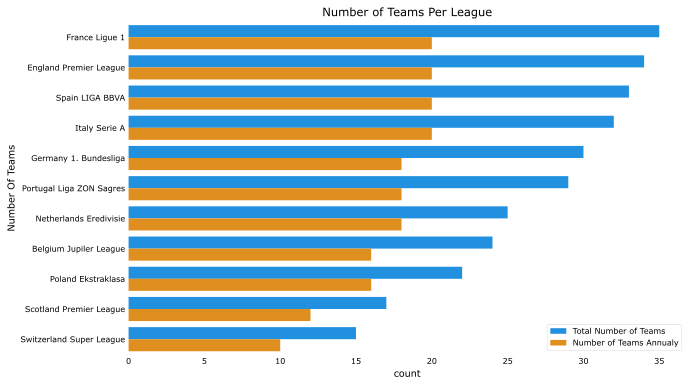

In [92]:
plt.figure(figsize=(10, 6))
fig = sns.barplot(data=merged_league_team,
                  x='count',
                  y='league_name',
                  hue='type',
                  dodge=True,
                  linewidth=2)
plt.title('Number of Teams Per League')
hide_spines(fig)
plt.ylabel('Number Of Teams')
plt.legend()
plt.show()

- Our bar chart above displays the number of teams participating annually and the total number of teams that have participated from 2008-2016.


- Each season, 20 teams compete in leagues in Spain, Italy, England, and France. The Portuguese, Dutch, and German leagues have 18 teams per season, whereas the Belgian and Polish leagues have 16, and the Scottish and Swiss leagues have 12 and 10, respectively. The number of clubs competing per season in some leagues might fluctuate. 


- We can also see that the French League has had the highest number of teams come in and out of the league throughout the years, followed by the English league. This occurs because of a process called relegation, where the best-ranked team(s) in a lower division are promoted to a higher division for the next season, and the worst-ranked team(s) in the higher division are relegated to the lower division for the next season.

**Which leagues score the most/fewest goals?**

In [14]:
# Top scoring leagues from 2008-2016
q = """
SELECT 
       l.name AS league,
       SUM(home_team_goal) AS total_home_goals,
       SUM(away_team_goal) AS total_away_goals,
       SUM(home_team_goal + away_team_goal) AS total_goals
FROM League l
JOIN Match m ON l.id = m.league_id
GROUP BY league
ORDER BY total_goals DESC
"""
leauge_goals_df = pd.read_sql(q, conn)
leauge_goals_df_melted = leauge_goals_df.melt(
    id_vars='league',
    value_vars=['total_home_goals', 'total_away_goals'],
    var_name='goals_type',
    value_name='number_of_goals')

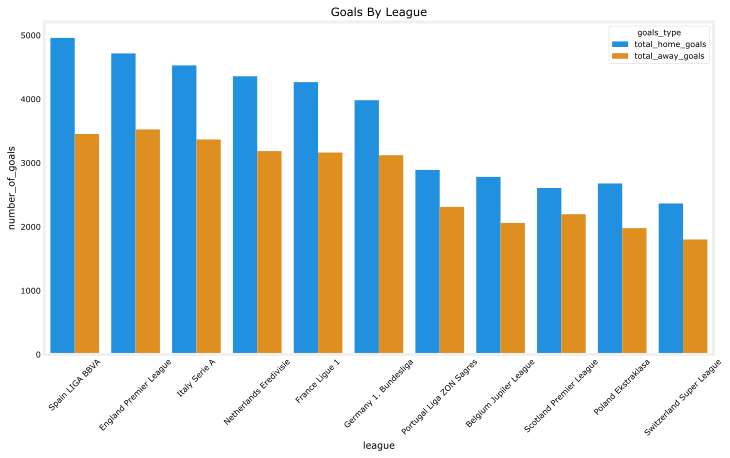

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(leauge_goals_df_melted,
            x='league',
            y='number_of_goals',
            hue='goals_type')
plt.title('Goals By Leagues')
plt.xticks(fontsize=8, rotation=45)
plt.show()

- Our bar chart displays the leagues that have scored the most goals from seasons 2008-2016. We can the Spanish,English and Italian leagues tend to be the highest scoring. That being said we have to take into account that some leagues have more team, which then results in more games and more goals.

**League Predictability Based on Betting Odds**

In [10]:
# Chose the betting odds containing the least amount of null values throughout seasons
home_cols = ['B365H', 'BWH', 'IWH', 'LBH', 'VCH', 'WHH']
away_cols = ['B365A', 'BWA', 'IWA', 'LBA', 'VCA', 'WHA']
draw_cols = ['B365D', 'BWD', 'IWD', 'LBD', 'VCD', 'WHD']

In [11]:
# Prepare strings to make sql query cleaner
avg_home_odds = f"({'+'.join(home_cols)})/{len(home_cols)} AS average_home_odds"
avg_away_odds = f"({'+'.join(away_cols)})/{len(away_cols)} AS average_away_odds"
avg_draw_odds = f"({'+'.join(draw_cols)})/{len(draw_cols)} AS average_draw_odds"

In [12]:
q = f"""
SELECT
    h.team_long_name AS home_team,
    a.team_long_name AS away_team,
    match_api_id as match_id,
    l.name AS league_name,
    season,
    home_team_api_id,
    away_team_api_id,
    {avg_home_odds},
    {avg_away_odds},
    {avg_draw_odds},
    CASE
        WHEN home_team_goal > away_team_goal THEN 'home_win'
        WHEN away_team_goal > home_team_goal THEN 'away_win'
        ELSE 'draw'
    END AS match_outcome
FROM Match m
JOIN League l ON m.league_id = l.id
JOIN Team h ON m.home_team_api_id = h.team_api_id
JOIN Team a ON m.away_team_api_id = a.team_api_id
"""

odds_df = pd.read_sql(q, conn)
odds_df = odds_df.copy().dropna(
    subset=['average_home_odds', 'average_away_odds', 'average_draw_odds'])

In [13]:
# The expected outcome is the outcome associated with the lowest odds
# Lower odd means that an event is more likely to happen
odds_df['expected_outcome'] = odds_df.apply(expected_outcome, axis=1)
# Add a 1 if the expected was = to the actual if not put a 0
odds_df['correct_prediction'] = (
    odds_df['expected_outcome'] == odds_df['match_outcome']).astype(int)

In [14]:
# Group by each season and league
predictability_season = odds_df.groupby(['season', 'league_name']).agg(
    num_matches=('league_name', 'count'),
    correct_preds=('correct_prediction', 'sum')).reset_index()
# Compute the percentage of time for each season/league the odds were correct (per match)
predictability_season['correct_percentage'] = (
    predictability_season['correct_preds'] /
    predictability_season['num_matches']) * 100

In [15]:
# Compute the average for each league to get a more general sense
avg_predictability = predictability_season.groupby('league_name').agg(
    avg_correct=('correct_percentage', 'mean')).reset_index()
avg_predictability = avg_predictability.sort_values(by='avg_correct',
                                                    ascending=False)

In [16]:
predictability_pivot_season = predictability_season.pivot(
    index='season', columns='league_name', values='correct_percentage')

In [17]:
avg_predictability

,league_name,avg_correct
8,Spain LIGA BBVA,56.096134
5,Netherlands Eredivisie,55.608125
6,Portugal Liga ZON Sagres,54.547039
4,Italy Serie A,53.444555
1,England Premier League,53.193480
0,Belgium Jupiler League,52.736035
3,Germany 1. Bundesliga,51.395481
7,Scotland Premier League,50.780393
2,France Ligue 1,50.462963


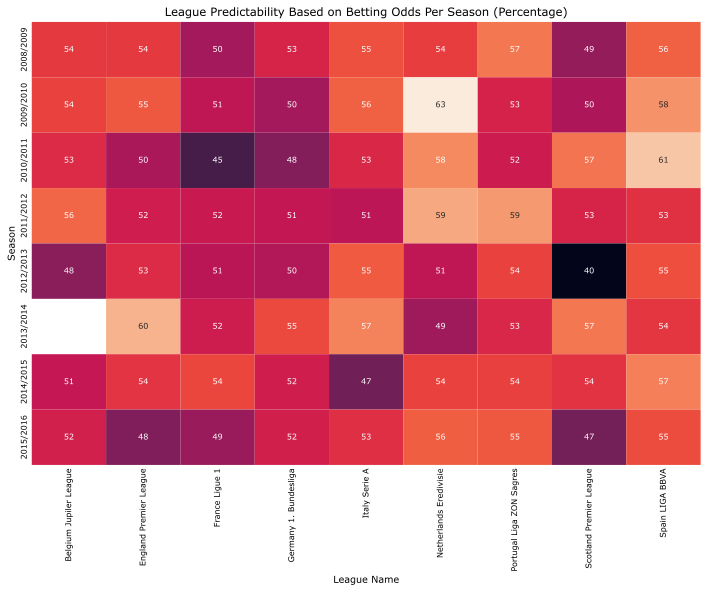

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(predictability_pivot_season, annot=True,cbar=False)
plt.title(
    'League Predictability Based on Betting Odds Per Season (Percentage)')
plt.xlabel('League Name')
plt.ylabel('Season')
plt.show()

- By utilizing the betting odds, we were able to come up with a naive solution for understanding the most predictable leagues and seasons based on the betting odds. The first step was to extract all the match data for each season and league. Then by using the home, away and draw odds we were able to construct the expected outcome. How? Well, the expected outcome is the outcome associated with the lowest odds (the favorite to win the match). By computing all the times the favored team won a match divided by the total number of matches(per league and season), we were able to get a percentage for each league and season. This approach states that if we bet on the favored team each time, we have a X % chance of that team winning.


- We can see that on average the Spanish,Dutch and Portuguese leagues tended to be most predictable based on the betting odds. We can also see that the predictabilities based on the odds varies slightly for each team and season that being said most of the time it lies around 50-60%.


- From a betting company's perspective, the heatmap is valuable for guiding where to allocate resources. Focusing on leagues with higher predictability could be a useful guide into making safer bets and utilizing the odds we have at hand.

**What are some of the highest performing teams in terms of winning?**

In [20]:
q = """
WITH home_game_results AS (
    SELECT 
        c.name AS country,
        season,
        l.name AS league,
        team_long_name AS team,
        home_team_api_id,
        SUM(CASE WHEN home_team_goal > away_team_goal THEN 1 ELSE 0 END) AS home_wins,
        SUM(CASE WHEN home_team_goal = away_team_goal THEN 1 ELSE 0 END) AS home_ties,
        SUM(CASE WHEN home_team_goal < away_team_goal THEN 1 ELSE 0 END) AS home_loss,
        SUM(home_team_goal) AS home_goals,
        SUM(away_team_goal) AS home_goals_conceded,
        AVG(home_team_goal) AS avg_home_goals
    FROM Team t
    JOIN Match m ON t.team_api_id = m.home_team_api_id
    JOIN league l ON m.league_id = l.id
    JOIN country c ON l.country_id = c.id
    GROUP BY team,season
),
away_game_results AS (
    SELECT 
        c.name AS country,
        season,
        l.name AS league,
        team_long_name AS team,
        SUM(CASE WHEN away_team_goal > home_team_goal THEN 1 ELSE 0 END) AS away_wins,
        SUM(CASE WHEN away_team_goal = home_team_goal THEN 1 ELSE 0 END) AS away_ties,
        SUM(CASE WHEN away_team_goal < home_team_goal THEN 1 ELSE 0 END) AS away_loss,
        SUM(away_team_goal) AS away_goals,
        SUM(home_team_goal) AS away_goals_conceded,
        AVG(away_team_goal) AS avg_away_goals
    FROM Team t
    JOIN Match m ON t.team_api_id = m.away_team_api_id
    JOIN league l ON m.league_id = l.id
    JOIN country c ON l.country_id = c.id
    GROUP BY team,season)
    
SELECT 
       h.country,
       h.season,
       h.league,
       h.team,
       home_team_api_id AS team_api_id,
       home_wins,
       away_wins,
       (home_wins + away_wins) AS total_wins,
       home_ties,
       away_ties,
       (home_ties + away_ties) AS total_ties,
       home_loss,
       away_loss,
       home_goals,
       away_goals,
       h.avg_home_goals,
       a.avg_away_goals,
       (home_goals - home_goals_conceded) AS home_goal_diff,
       (away_goals - away_goals_conceded) AS away_goal_diff,
      ((home_goals + away_goals) - (home_goals_conceded + away_goals_conceded)) AS overall_goal_diff,
       home_goals + away_goals AS total_goals,
       (home_loss + away_loss) AS total_losses,
       (home_wins * 1.0) / (home_wins + home_loss + home_ties) AS home_win_pct,
       (home_loss * 1.0) / (home_wins + home_loss + home_ties) AS home_loss_pct,
       (home_ties * 1.0) / (home_wins + home_loss + home_ties) AS home_draw_pct,
       (away_wins * 1.0) / (away_wins + away_loss + away_ties) AS away_win_pct,
       (away_loss * 1.0) / (away_wins + away_loss + away_ties) AS away_loss_pct,
       (away_ties * 1.0) / (away_wins + away_loss + away_ties) AS away_draw_pct,
       ((home_wins + away_wins)* 1.0) / 
       (home_wins + away_wins + home_ties + away_ties+ home_loss + away_loss) AS overall_win_pct,
       ((home_loss + away_loss)* 1.0) / 
       (home_wins + away_wins + home_ties + away_ties+ home_loss + away_loss) AS overall_loss_pct,
        ((home_ties + away_ties) * 1.0) / 
       (home_wins + away_wins + home_ties + away_ties+ home_loss + away_loss) AS overall_draw_pct,
       home_wins + home_loss + home_ties AS total_home_games,
       away_wins + away_loss + away_ties AS total_away_games,
       home_wins + away_wins + home_ties + away_ties+ home_loss + away_loss AS total_games,
       (3 * (home_wins + away_wins)) + (home_ties + away_ties) AS total_points

FROM home_game_results h
JOIN away_game_results a 
ON h.team = a.team AND h.season = a.season
ORDER BY overall_win_pct DESC
"""
team_stats_wins_losses_df_season = pd.read_sql(q, conn)

In [121]:
team_stats_wins_losses_df_season.sort_values(by='season').head()

,country,season,league,team,team_api_id,home_wins,away_wins,total_wins,home_ties,away_ties,total_ties,home_loss,away_loss,home_goals,away_goals,avg_home_goals,avg_away_goals,home_goal_diff,away_goal_diff,overall_goal_diff,total_goals,total_losses,home_win_pct,home_loss_pct,home_draw_pct,away_win_pct,away_loss_pct,away_draw_pct,overall_win_pct,overall_loss_pct,overall_draw_pct,total_home_games,total_away_games,total_games,total_points
1372,France,2008/2009,France Ligue 1,Le Havre AC,9746,4,3,7,0,5,5,15,11,17,13,0.894737,0.684211,-17,-20,-37,30,26,0.210526,0.789474,0.000000,0.157895,0.578947,0.263158,0.184211,0.684211,0.131579,19,19,38,26
744,Portugal,2008/2009,Portugal Liga ZON Sagres,Académica de Coimbra,10215,8,2,10,5,4,9,2,9,18,10,1.200000,0.666667,5,-9,-4,28,11,0.533333,0.133333,0.333333,0.133333,0.600000,0.266667,0.333333,0.366667,0.300000,15,15,30,39
476,Italy,2008/2009,Italy Serie A,Udinese,8600,11,5,16,5,5,10,3,9,36,25,1.894737,1.315789,18,-7,11,61,12,0.578947,0.157895,0.263158,0.263158,0.473684,0.263158,0.421053,0.315789,0.263158,19,19,38,58
740,Spain,2008/2009,Spain LIGA BBVA,UD Almería,9865,11,2,13,4,3,7,4,14,27,18,1.421053,0.947368,7,-23,-16,45,18,0.578947,0.210526,0.210526,0.105263,0.736842,0.157895,0.342105,0.473684,0.184211,19,19,38,46
239,Belgium,2008/2009,Belgium Jupiler League,Club Brugge KV,8342,11,7,18,2,3,5,4,7,37,22,2.176471,1.294118,14,-5,9,59,11,0.647059,0.235294,0.117647,0.411765,0.411765,0.176471,0.529412,0.323529,0.147059,17,17,34,59


In [21]:
# Get the overall win_pcts and stats for each team
teams_overall_stats = team_stats_wins_losses_df_season.groupby('team')[[
    'overall_win_pct', 'home_win_pct', 'away_win_pct'
]].mean().reset_index().sort_values(by='overall_win_pct', ascending=False)
teams_overall_stats = teams_overall_stats[teams_overall_stats['team'] !=
                                          'Rangers']
top_20 = teams_overall_stats.head(20).copy()

In [22]:
# Convert decimals to percentages
top_20['overall_win_pct'] = top_20['overall_win_pct'] * 100
top_20['home_win_pct'] = top_20['home_win_pct'] * 100
top_20['away_win_pct'] = top_20['away_win_pct'] * 100
top_10 = top_20.head(10)

In [23]:
# Melt dataframe for plotting with legend
melted_team_stats = top_10.melt(
    id_vars='team',
    value_vars=['overall_win_pct', 'home_win_pct', 'away_win_pct'],
    value_name='percentage',
    var_name='win_type')

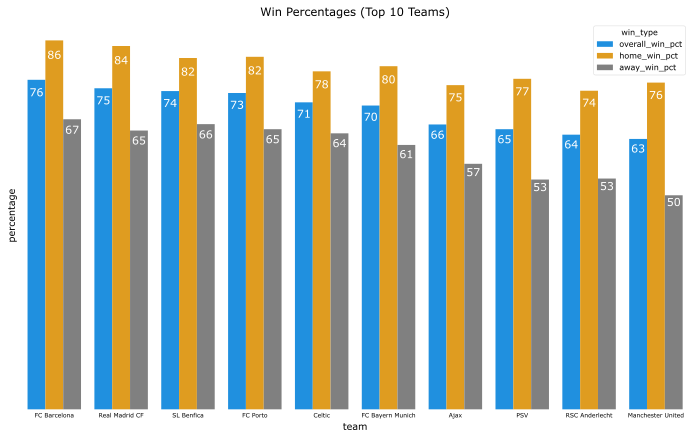

In [143]:
custom_palette = {
    'home_win_pct': 'orange',
    'away_win_pct': 'grey',
    'overall_win_pct': default_blue
}
plt.figure(figsize=(12, 7))

fig = sns.barplot(melted_team_stats,
                  x='team',
                  y='percentage',
                  hue='win_type',
                  palette=custom_palette)
annotate_bars(fig, lim=0)
plt.yticks([])
hide_spines(fig)
plt.title('Win Percentages (Top 10 Teams)')
plt.xticks(fontsize=6)
plt.show()

- We created a data frame the contains seasonal stats for each team. We see that per season, each team plays every other team 2 times once at home and once away. So if there is 20 teams, each team plays 19 other teams two times totaling to 38 matches for the season. Each league varies depending on the number of active teams.


- The bar plot above displays some of the top 10 teams throughout the season ranked by win percentages. We can see that FC Barcelona has the highest overall win percentage at around 86%. Their home win percentage is sitting at around 76% and away win percentage at 67%. Not far behind is Real Madrid, SL Benifica, and FC Porto with high win percentages.


- Based on these observations, this gives some insight in some potential high performing teams. From a betting company's perspective, this gives us a general overview on some teams that we can keep our eyes for placing potential lower risk bets, given that some of these teams have a  high win percentages.


- In our modeling phase we will be using some of these stats as features in order to predict future matches, given that they could play a significant role in predicting match outcome.

**How have some of the top teams performance changed over the season?**

In [24]:
# Prepare data for heatmap of top 20 teams
heatmap_data_win_pct = team_stats_wins_losses_df_season[
    team_stats_wins_losses_df_season['team'].isin(top_20.team)].pivot_table(
        index="team", columns="season", values="overall_win_pct")

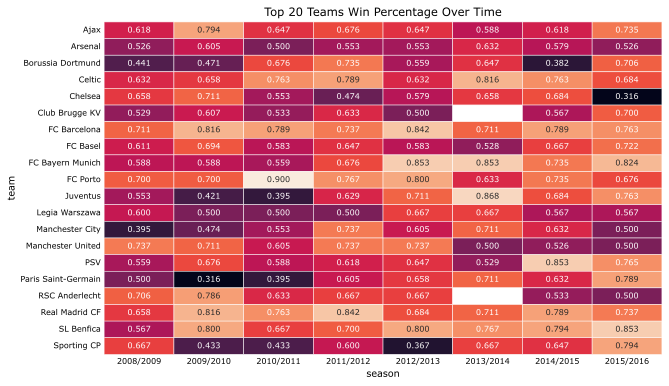

In [27]:
plt.figure(figsize=(10, 6))
plt.title('Top 20 Teams Win Percentage Over Time')
sns.heatmap(heatmap_data_win_pct, annot=True, fmt=".3f", linewidths=.5,cbar=False)
plt.show()

- Our heatmap analysis displays the win percentage of the top 20 European football teams over eight seasons, from 2008 to 2016. The visualization provides insights into the performance trends of these clubs, with teams like FC Barcelona and Real Madrid CF consistently maintaining impressive win percentages above 70%, illustrating their sustained dominance in European football.


- Teams such as FC Barcelona and Real Madrid CF show pretty consistent performances throughout the seasons. Teams like Juventus,Paris Saint-Germain, and SL Benfica seem to have improved significantly through the years. That being said, teams such as Manchester United,Chelsea, and RSC Anderlecht's performances seemed to have fluctuated a bit more downward.


- From a betting company perspective, these performance insights offer valuable insights for assessing risk and identifying potential. The consistency of teams like FC Barcelona and Real Madrid CF makes them generally safer bets. However, the rising performances of teams like Juventus, Paris Saint-Germain, and SL Benfica could represent more intriguing options. On the flip side, the fluctuating form of clubs like Manchester United, Chelsea, and RSC Anderlecht may introduce a higher level of unpredictability, suggesting more caution or perhaps an opportunity for high-reward bets if timed correctly.

**Where Do Teams Win The Most (Home or Away)?**

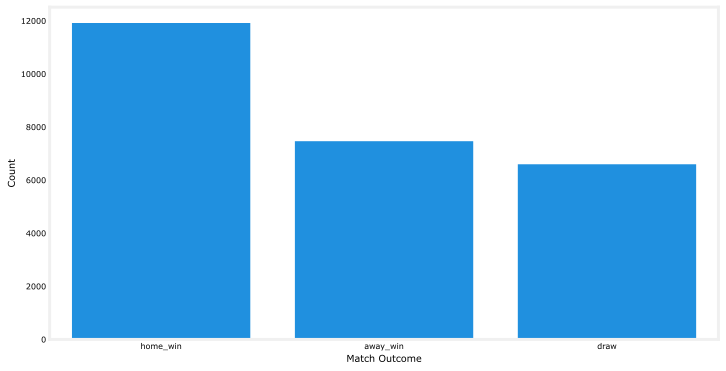

In [189]:
match_outcomes = pd.DataFrame(
    odds_df['match_outcome'].value_counts().reset_index())
plt.figure(figsize=(12, 6))
sns.barplot(match_outcomes, x='index', y='match_outcome', color=default_blue)
plt.xlabel('Match Outcome')
plt.ylabel('Count')
plt.show()

- Our bar plot shows us the distribution of match outcomes. Right away we can see its much more common for home teams to win then it is for away teams or a draw.

**Is There Such Thing as Home Advantage?**

**Null Hypothesis (H0)**: The average difference between home win percentage and away win percentage is 0 (i.e., on average, there's no difference between playing at home or away).

**Alternative Hypothesis (H1)**: The average difference between home win percentage and away win percentage is greater than 0. (i.e., on average teams have a higher win percentage at home).

In [149]:
team_stats_wins_losses_df = team_stats_wins_losses_df_season.groupby('team')[[
    'home_win_pct', 'away_win_pct'
]].mean().reset_index().sort_values(by='home_win_pct', ascending=False)
team_stats_wins_losses_df[
    'home_win_pct'] = team_stats_wins_losses_df['home_win_pct'] * 100
team_stats_wins_losses_df[
    'away_win_pct'] = team_stats_wins_losses_df['away_win_pct'] * 100

In [150]:
# Compute the difference of home vs away win percentage
team_stats_wins_losses_df['difference_home_away'] = team_stats_wins_losses_df[
    'home_win_pct'] - team_stats_wins_losses_df['away_win_pct']

In [151]:
x_range = create_xlim(team_stats_wins_losses_df, 'home_win_pct',
                      'away_win_pct')

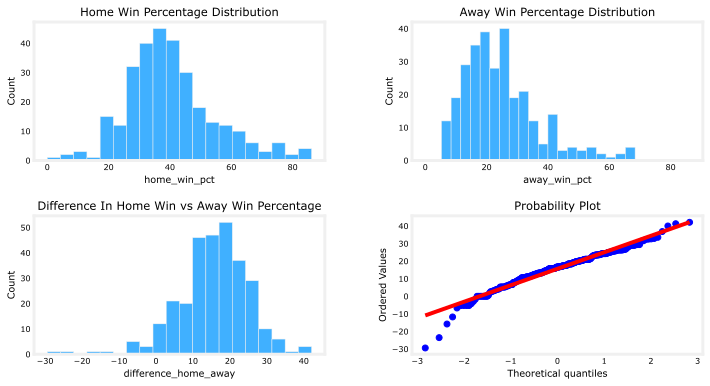

In [152]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title('Home Win Percentage Distribution')
sns.histplot(team_stats_wins_losses_df['home_win_pct'], bins=20)
plt.xlim(x_range)
plt.subplot(2, 2, 2)
plt.title('Away Win Percentage Distribution')
sns.histplot(team_stats_wins_losses_df['away_win_pct'], bins=20)
plt.xlim(x_range)

plt.subplot(2, 2, 3)
sns.histplot(team_stats_wins_losses_df['difference_home_away'], bins=20)
plt.title('Difference In Home Win vs Away Win Percentage')
plt.subplot(2, 2, 4)
stats.probplot(team_stats_wins_losses_df['difference_home_away'],
               dist="norm",
               plot=plt)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [67]:
alpha = 0.025

tstat, pval = stats.ttest_rel(team_stats_wins_losses_df['home_win_pct'],
                              team_stats_wins_losses_df['away_win_pct'],
                              alternative='greater')
print(f"Our T-statistic is {tstat} and our P-value is {pval}")

Our T-statistic is 28.603589362265527 and our P-value is 2.3076012699371435e-87


- In order to understand if there is such thing as home advantage, I decided to take the approach by computing the home win and away win percentage for each team, and comparing the difference. 


- Examining the distributions of win percentages, we see that teams tend to have a higher win rate at home, with an average home win percentage of approximately 40%, compared to an average away win percentage of roughly 25%. This initial insight suggests that teams are generally more successful at securing wins in their home venue than when playing away. 


- I decided to use a paired t-test in order to compare the difference between a teams home win percentage and there away win percentages in order to determine if the home win percentage is significantly greater than the away (one tailed test).


- Given the p-value obtained from our test, which is substantially below the alpha threshold of 0.025, we reject the null hypothesis.This indicates that there is a statistically significant difference in winning percentages for teams playing at home compared to away, implying the presence of a home advantage effect.

**Team Predictability Based on Betting Odds**

In [14]:
q = """
SELECT 
    DISTINCT team_long_name
FROM team t
JOIN Match m ON t.team_api_id = home_team_api_id
WHERE season = '2015/2016'
"""
latest_teams = pd.read_sql(q, conn)

In [46]:
# Compute the correct predictions (odds) for home teams
home_preds = odds_df.groupby('home_team').agg(
    home_matches=('match_id', 'count'),
    home_correct=('correct_prediction', 'sum'))
# Compute the correct predictions (odds) for away teams
away_preds = odds_df.groupby('away_team').agg(
    away_matches=('match_id', 'count'),
    away_correct=('correct_prediction', 'sum'))
# Combined them
predictability = home_preds.merge(
    away_preds,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=('_home',
              '_away')).reset_index().rename(columns={'index': 'team'})
# Combined and get predicability scores for each team
predictability['total_matches'] = predictability[
    'home_matches'] + predictability['away_matches']
predictability['total_correct'] = predictability[
    'home_correct'] + predictability['away_correct']
predictability['predictability_score'] = predictability[
    'total_correct'] / predictability['total_matches']

In [84]:
# Get the top 10 teams
top_10_predictability = predictability.sort_values(
    by='predictability_score',
    ascending=False).rename(columns={'home_team': 'team_name'})
top_10_predictability_current = top_10_predictability[
    top_10_predictability['team_name'].isin(
        latest_teams['team_long_name'])].head(10)
top_10_predictability_current[
    'predictability_score'] = top_10_predictability_current[
        'predictability_score'] * 100

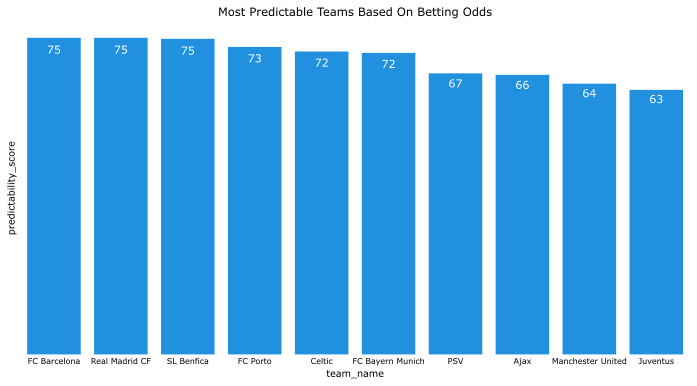

In [148]:
plt.figure(figsize=(12, 6))
plt.title('Most Predictable Teams Based On Betting Odds')
fig = sns.barplot(top_10_predictability_current,
                  x='team_name',
                  y='predictability_score',
                  color=default_blue)
hide_spines(fig)
annotate_bars(fig, lim=0)
plt.yticks([])
plt.show()

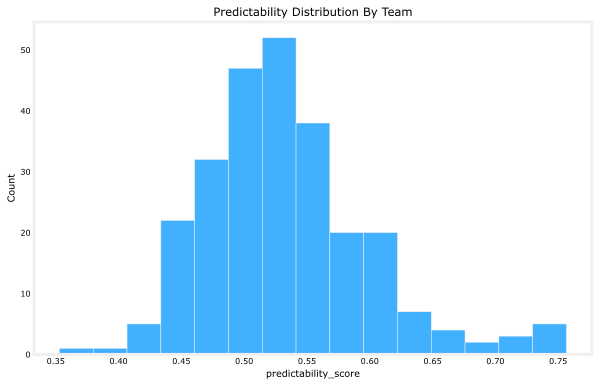

In [86]:
plt.figure(figsize=(10, 6))
sns.histplot(predictability['predictability_score'], bins=15)
plt.title('Predictability Distribution By Team')
plt.show()

In [87]:
predictability['predictability_score'].describe()

count    259.000000
mean       0.533149
std        0.066534
min        0.352941
25%        0.488410
50%        0.524752
75%        0.565964
max        0.756579
Name: predictability_score, dtype: float64

- The bar chart above shows the predictability of match outcomes based on betting odds for different teams. The predictability_score indicates the percentage of times the match outcome, as suggested by the odds, was accurate. For instance, for FC Barcelona and Real Madrid CF, the odds correctly predicted the match outcome approximately 75.6% of the time. This provides a naive assessment of the reliability of betting odds for each team.


- The histogram's central tendency at a predictability score of 0.54 (54%) indicates that betting odds are right just over half the time, with a slight variation (standard deviation of 0.06). This indicates that the bookier gets it right about 54% of the time.Higher predictability is rare, emphasizing the uncertainty in betting outcomes.


- From a betting company perspective, this could mean that placing bets based on the odds for these high-scoring teams could be a strategic approach, potentially leading to a higher success rate in predictions. This insight could help inform betting strategies, particularly for matches involving consistently high-scoring teams. When we enter our modeling phase, we will be utilizing the betting odds for each match.

**Do teams tend to score more goals at home vs away?**

**Null Hypothesis (H0)**: There is no difference in the distribution of goals scored in home games versus away games.

**Alternative Hypothesis (H1)**: The distribution of goals scored in home games is greater than in away games, suggesting that more goals tend to be scored in home games than away games

In [159]:
match_attributes = match_with_player_attributes[[
    'match_api_id', 'home_team_api_id', 'away_team_api_id', 'match_outcome',
    'home_team_goal', 'away_team_goal', 'home_overall_rating',
    'away_overall_rating'
]].copy()

In [149]:
x_lim = create_xlim(match_attributes, 'home_team_goal', 'away_team_goal')

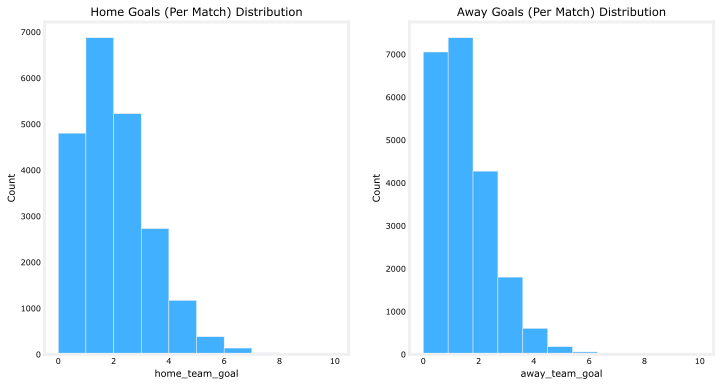

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(match_attributes['home_team_goal'], bins=10)
plt.title('Home Goals (Per Match) Distribution')
plt.xlim(x_lim)
plt.subplot(1, 2, 2)
sns.histplot(match_attributes['away_team_goal'], bins=10)
plt.title('Away Goals (Per Match) Distribution')
plt.xlim(x_lim)
plt.show()

In [119]:
alpha = 0.025
u_stat, p_val = stats.mannwhitneyu(match_attributes['home_team_goal'],
                                   match_attributes['away_team_goal'],
                                   alternative='greater')
print(f"Our U-Statistic is {u_stat} and our P-value is {p_val}")

Our U-Statistic is 267466213.5 and our P-value is 1.7462899354056398e-221


- After investigating win percentages between teams, I was naturally curious to understand if teams score more goals at home than away. First, we start by plotting the distributions for goals scored at home and goals scored away (per match). Just at first glance, we see that more goals are scored more frequently at home than away.


- In order to test our hypothesis, we utilized a Mann-Whitney U test because the assumptions of a normal t-test for comparing means were not met. We performed a one-tailed test to see if the distribution of goals scored in home games is greater than in away games. The test resulted in a p-value much smaller than our alpha level, thus suggesting that more goals tend to be scored in home games than away games.


- This information can also be used when developing our model to predict the number of goals a team scores in a given match. 

**Does a teams overall rating have an impact on the number of goals scored?**

In [28]:
# Select relevant features for correlation
match_attr_subset = match_with_player_attributes[[
    'home_team_goal', 'away_team_goal', 'home_shot_power', 'away_shot_power',
    'home_positioning', 'away_positioning', 'home_overall_rating',
    'away_overall_rating'
]]

In [29]:
match_attr_subset_corr = match_attr_subset.corr()

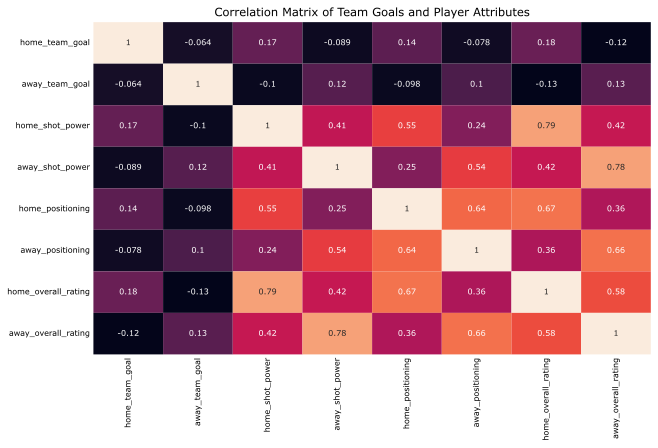

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(match_attr_subset_corr, annot=True,cbar=False)
plt.title('Correlation Matrix of Team Goals and Player Attributes')
plt.show()

- Our heatmap above shows us some of the features of a team that are correlated with the number of goals they score. We can see that attributes like overall rating, positioning, and shot power all have mild correlation with goals scored.


- This could be acting as potential features when are trying to predict the number of goals a team will score, these features also can impact a match outcome given that they contribute towards goals.

**Does being a higher rated overall team impact the outcome of a match?**

In [34]:
q = """
SELECT *
FROM Player_attributes
"""
df_playerattr = pd.read_sql(q, conn)
numeric_stats = df_playerattr.select_dtypes(include=np.number)
numeric_stats = numeric_stats.columns[3:-1]

In [61]:
# Create column that has higher rated team (home or away)
match_attributes['team_with_higher_rating'] = np.where(
    match_attributes['home_overall_rating']
    > match_attributes['away_overall_rating'], 'home', 'away')
# Assign a 1 if the higher rated team won, if not 0
match_attributes['higher_rated_won'] = np.where(
    (match_attributes['team_with_higher_rating'] == 'home') &
    (match_attributes['match_outcome'] == 'home_win') |
    (match_attributes['team_with_higher_rating'] == 'away') &
    (match_attributes['match_outcome'] == 'away_win'), 1, 0)

In [62]:
# Compute the absolute rating differnce between teams
match_attributes['rating_difference'] = (
    match_attributes['home_overall_rating'] -
    match_attributes['away_overall_rating']).abs()
# Bin the rating differences in increments of 5
bins_rating_diff = pd.cut(match_attributes['rating_difference'],
                          bins=[0, 5, 10, 15, 20])
# Group by those bins and compute the percentage
# of times the higher rated team grouped by difference of rating
grouped_ratings_diff = match_attributes.groupby(
    bins_rating_diff)['higher_rated_won'].mean().reset_index()

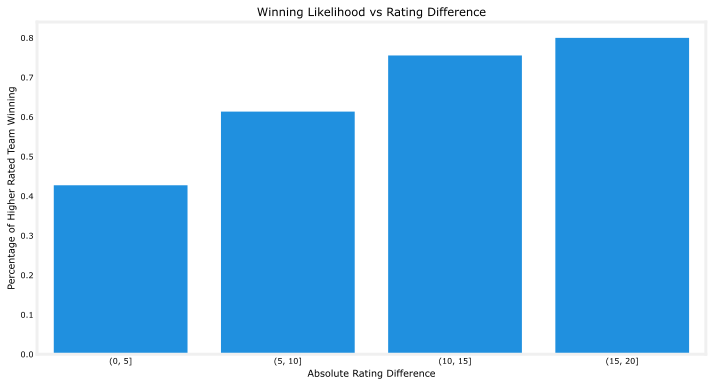

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(grouped_ratings_diff,
            x='rating_difference',
            y='higher_rated_won',
            color=default_blue)
plt.xlabel('Absolute Rating Difference')
plt.ylabel('Percentage of Higher Rated Team Winning')
plt.title('Winning Likelihood vs Rating Difference')
plt.show()

- I wanted to understand how the overall rating of a team (all the player ratings averaged per team) affects the outcome of a match. First, we computed the number of times the higher-rated team won a match. Following each match, we calculated the absolute difference in ratings between the teams. Then, by grouping the difference in ratings for the matches by increments of 5, we were able to compute how many times the higher-rated team won for each group.


- As we can see from our barplot, when the difference in rating between the teams is smaller, the percentage of the higher-rated team winning is a bit less than 50%. But as the difference in ratings between two teams gets larger, the chance of the higher-rated team winning gets much larger.


- From a betting company perspective, this gives us some insight on when to be cautious when betting on teams that highly differ in ratings. This will also be a useful feature for our modelling phase when trying to predict match outcomes.


**How do team attributes influence there performance (winning and goal scoring)?**

In [35]:
q = """
SELECT *
FROM team_attributes ta
JOIN team t ON ta.team_api_id = t.team_api_id
ORDER BY date
"""
team_attr_df = pd.read_sql(q, conn)

In [36]:
# Drop null ,remove duplicates, convert date column
team_attr_df = team_attr_df.drop(columns=['buildUpPlayDribbling'])
team_attr_df = team_attr_df.loc[:, ~team_attr_df.columns.duplicated()]
team_attr_df['date'] = pd.to_datetime(team_attr_df['date'])

In [37]:
# Get numerical columns
team_attr_df_numerical = team_attr_df.select_dtypes(include=np.number)
cols_stats = list(team_attr_df_numerical.columns[3:-1])

In [38]:
# Remove duplicate of numerical columns
team_attr_df_numerical['team'] = team_attr_df['team_long_name']
team_attr_df_numerical = team_attr_df_numerical.loc[:, ~team_attr_df_numerical.
                                                    columns.duplicated()]
# Get each teams average team attributes
team_df_grouped = team_attr_df_numerical.groupby(
    'team')[cols_stats].mean().reset_index()

In [39]:
# Exclude 2008-2009 since there was no team attributes during that season
team_stats_with_attributes = team_stats_wins_losses_df_season[
    team_stats_wins_losses_df_season['season'] != '2008/2009']

In [40]:
aggregations = {
    'total_wins': 'sum',
    'total_ties': 'sum',
    'total_losses': 'sum',
    'total_goals': 'sum',
    'total_home_games': 'sum',
    'total_away_games': 'sum',
    'total_games': 'sum',
    'overall_win_pct': 'mean',
    'overall_loss_pct': 'mean',
    'overall_draw_pct': 'mean',
}

In [41]:
# Compute team stats for each team
team_stats_with_attributes = team_stats_with_attributes.groupby('team').agg(
    aggregations).reset_index()

In [42]:
# Merge with  player attributes to compare in corr matrix
merged_team = team_df_grouped.merge(team_stats_with_attributes,
                                    on='team').sort_values(by='total_goals',
                                                           ascending=False)

In [43]:
corr_matrix = merged_team[cols_stats + [
    'total_wins', 'total_goals', 'overall_win_pct', 'overall_loss_pct'
]].corr(numeric_only=True)

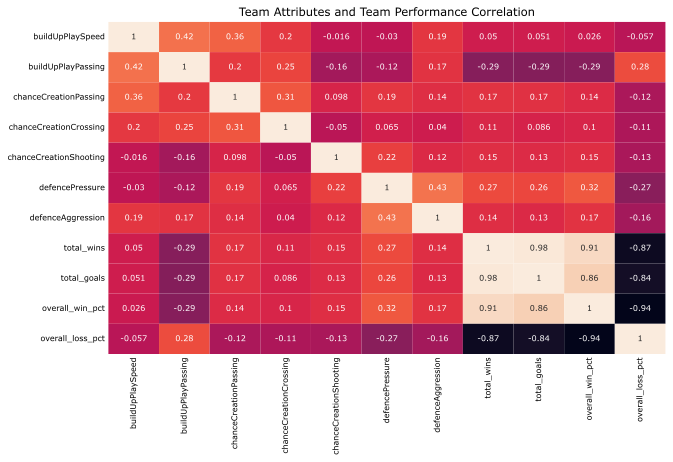

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True,cbar=False)
plt.title('Team Attributes and Team Performance Correlation')
plt.show()

- Our heatmap displays a correlation matrix between averaged team attributes from 2010-2016 and performance metrics over the same seasons. This offers insights into how various play styles may impact team success.


- The data indicates that defensive intensity (captured by defence pressure and aggression) and proactivity in creating shots and passes (evidenced by chance creation shooting and passing) correlate positively with winning outcomes, goal counts, and overall win rates. Slower build-up play passing speed is negatively correlated to these performance indicators.

**Conclusion**

In conclusion of our data analysis from 2008 to 2016, we've uncovered several key findings for our sports betting endeavors. Annually, leagues like Spain's La Liga, Italy's Serie A, England's Premier League, and France's Ligue 1 consistently feature 20 teams, while the Portuguese, Dutch, and German leagues consist of 18, whereas some of the smaller leagues consisted of 10-16. Scoring patterns have revealed that the Spanish, English, and Italian leagues are the highest-scoring, with La Liga leading the pack. 



Our analysis of league predictability by season led us to determine Spanish, Dutch, and Portuguese leagues,on average had the highest predictability according to the odds, with odds accuracy exceeding 50%. This can be crucial for betting strategies as it indicates a higher likelihood of outcomes aligning with expectations, thereby offering a more reliable basis for placing bets and forecasting returns. This predictability can serve as a guide to prioritize leagues for potential profit opportunities.



Performance analysis highlights top performing teams through out the years like FC Barcelona's overall win rate at 76%, Real Madrid with a overall win rate of 75% percent and SL Benifica with a win rate of 74%. Having a further look we were able to break down some of the top teams performances through out the seasons. We found that teams like Juventus, Paris Saint-Germain, and SL Benfica have shown significant improvements over the seasons, indicating potential as rising betting favorites, whereas clubs like Manchester United and Chelsea have experienced more variability, presenting opportunities for strategic high-value bets.


The investigation into home advantage using a paired t-test confirmed a statistically significant difference between home (average 40% win rate) and away (average 25% win rate) performances, highlighting the importance of factoring in venue when placing bets.


Further investigating we found  that the odds for teams like Barcelona, Real Madrid, and SL Benifica correctly predicted the match outcome approximately 75.6% of the time. We also determined that on average, the odds were correct 54% of the time indicating that higher predictability is rare, emphasizing the uncertainty in betting outcomes.



Having a look at goals at home vs away, we utilized a Mann-Whitney U test to compare the two distributions of home and away goals. The test resulted in a p-value much smaller than our alpha level, thus suggesting that more goals tend to be scored in home games than away games.This information can also be crucial for betting and trying to make predictions about the number of goals a team will score in given match.


When examining the impact of overall team ratings on match outcomes, we found that the likelihood of a higher-rated team winning increases substantially when the rating difference gets larger and larger 5 points. To be more precise, when the absolute rating difference is from 5-10 between teams the higher rated team tended to win the match around 60% of the time. When the rating difference is from 10-15 the higher rated team tended to win 70% of the time and when the difference was 15-20 the higher rated team won almost 80% of the time. This insight can sharpen betting strategies, especially in matchups with a clear ratings favorite. This can also provide for some value betting by betting on less favored teams when the rating difference is small.  



Our analysis of team attributes indicates a  positive correlation between defensive strategies like pressure and aggression and successful outcomes, while a slower build-up play is associated with higher win rates and goals scored. The data also showed high build-up play passing speed was negatively correlated with performance.


In essence, these data-driven insights can significantly refine our betting strategies, emphasizing the value of home advantage, the reliability of team performance metrics, and the predictive power of specific team attributes. As we develop predictive models, these factors will be important in predicting match outcomes and achieving a competitive edge in sports betting.